# <span style="color: blue;">Test Growth of R. cellulolyticum CarveMe model on various basic growth media with simple sugars. </span>

**A: Testing basic functionality**
- A.1: Growth on growth media used during CarveMe reconstruction.
- A.2: Determining the existence of energy producing cycles in the model. 
**B: Comparison with iFS431 model: Growth on cellobiose**
- B.1 Growth on cellobiose: *Carbon and electron flow in Clostridium cellulolyticumgrownin  chemostat  culture  on  synthetic  medium (Guedon et al., 1999)
- B.1.1 Test production of fermentation products and growth rate at the same dilution rate as in the modeling of iFS431.
**C: Testing the model on additional data.**
- C.1: Growth rate while varying the dilution rate. With data from Guedon et al. (1999)
- C.2: KO experiments with data from Kampik et al. (2021)
**D: ATP and biomass yield and growth rate on various sugars.**
- D.1. Testing ATP production on various sugars
- D.2. Testing growth production on various sugars. 

#### Importing tools

In [1]:
import reframed
from reframed import pFBA, Environment, FVA,FBA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict 
import warnings
plt.rcdefaults()

#### Loading model

In [2]:
model = reframed.load_cbmodel('model_c_H10_part4_1.xml')

In [3]:
model_old = reframed.load_cbmodel('model_cellulolyticum_H10.xml')

**Standard medium**
- **H10_minimal_glucose** is minimal media from *Handling Several Sugars at a Time: a Case Study of Xyloglucan Utilization by Ruminiclostridium cellulolyticum (Kampik et al.,2021)*


## <span style="color: blue;">A: Testing basic functionality. </span>

### <span style="color: blue;"> A.1: Growth on growth media used during CarveMe reconstruction.</span>

**Motivation**: Ensuring that the model is still able to grow on the media that literature states that it should be able to grow on. 

In [4]:
media = pd.read_csv('carveMe input/carveMe_medium.tsv',sep='\t')

In [5]:
media_ids = set(media['medium'])
media_FBA = {media_id:0 for media_id in media_ids} 
media_FBA_old = {media_id:0 for media_id in media_ids} 
for media_id in media_ids:
    media_list = list(media[media.medium==media_id]['compound'])
    env = Environment.from_compounds(media_list)
    
    with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
        warnings.simplefilter('ignore')
        env.apply(model,exclusive=True,inplace=True)
        env.apply(model_old,exclusive=True,inplace=True)
        
        sol = FBA(model)
        media_FBA[media_id]=sol
        
        sol_old = FBA(model_old)
        media_FBA_old[media_id]=sol_old

In [6]:
media_growth = OrderedDict(sorted({media_id:sol.fobj for media_id,sol in media_FBA.items()}.items()))
media_growth_old = OrderedDict(sorted({media_id:sol.fobj for media_id,sol in media_FBA_old.items()}.items()))

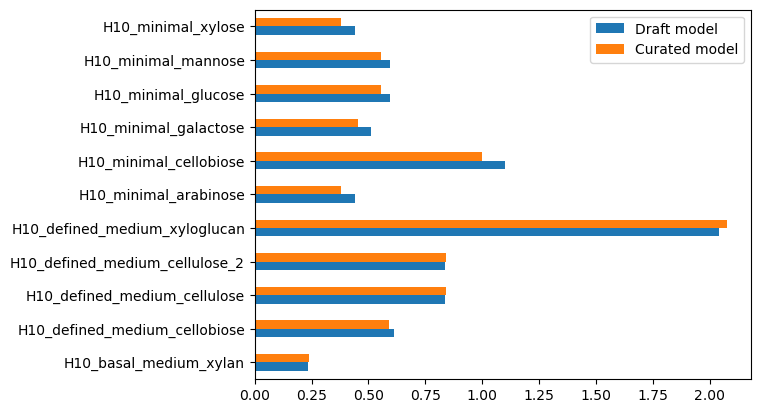

In [7]:
ax = pd.DataFrame({'Draft model':list(media_growth_old.values()),
              'Curated model':list(media_growth.values())},
             index=list(media_growth.keys())).plot.barh()

### <span style="color: blue;"> A.2: Determining the existence of energy producing cycles in the model. 

In [8]:
model_copy = model.copy()

In [9]:
env_empty = Environment.empty(model_copy)
model_copy.reactions.R_ATPM.lb=0
objective= {rxn:0 for rxn in model_copy.reactions}
objective['R_ATPM']=1

In [10]:
sol = FBA(model_copy,objective=objective,constraints=env_empty)


if sol.fobj ==0.0:
    print('There are NO energy producing cycles in the model')
else:
    print('There is at least one energy producing cycle in the model')
    sol_pfba = pFBA(model_copy,objective=objective,constraints=env_empty)
    
    print('These are the reactions that are a part of the energy producing cycle')
          
    for rxn,value in sol_pfba.values.items():
          if value>200:
              
              print("\t" + str(rxn)+": " + str(value))

There are NO energy producing cycles in the model


## <span style="color: blue;">B: Comparison with iFS431 model: Growth on cellobiose. </span>

The iFS431 model was created in 2010 for R. cellulolyticum. In this part we will test growth on the media that they used to test this model to see how the CarveMe model performs in comparison. 

**Motivation**: When presenting the new model, we should address how it is performing in comparison to the iFS431 model. 

#### The growth of iFS431 was tested based on this data: 
-  **B.1. Growth on cellobiose**: *Carbon and electron flow in Clostridium cellulolyticumgrownin  chemostat  culture  on  synthetic  medium (Guedon et al., 1999)*. 
    - **Used in CarveMe reconstruction**: H10_defined_medium_cellobiose
    - Model iFS431 has higher acetate production than the actual production. 
    - Model does not predict pyruvate formation. -> They put a constraint on the LDH and PFI to represent the maximal observed lactate production rate (0.3 mmol/g CDW/h)

### <span style="color: blue;">**B.1 Growth on cellobiose**: *Carbon and electron flow in Clostridium cellulolyticumgrownin  chemostat  culture  on  synthetic  medium (Guedon et al., 1999)*</span>. 

**The study**: In this study they calculated the specific uptake of cellobiose and production of fermentation products when growing R. cellulolyticum in a chemostat at various dilution rates. It was also used in the study where iFS431 was created (Salimi et al, 2010).

**Modeling of growth in iFS431**: Although they do not provide the info of how they obtain it in Guedon et al. (1999), the modelers have somehow calculated the uptake rates of Pi, NH4 and other nutrients. *To test the model, I will use this in my model as well.*


#### <span style="color: blue;"> Import data from this experiment (from CarveMe media input file) and use as environement</span>

In [11]:
with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    env_cellb=Environment.from_compounds(list(media[media.medium=='H10_defined_medium_cellobiose']['compound']))
    env_cellb.apply(model,exclusive=True,inplace=True)

In [12]:
sol = pFBA(model)

In [13]:
sol.show_values(pattern='Growth')

Growth        0.591072


In [14]:
sol.show_values(pattern='R_EX',sort=True)

R_EX_cellb_e -10
R_EX_h_e     -10
R_EX_nh4_e   -5.84686
R_EX_h2o_e   -5.32263
R_EX_pi_e    -0.517343
R_EX_so4_e   -0.148006
R_EX_k_e     -0.115373
R_EX_mg2_e   -0.00512755
R_EX_fe3_e   -0.00461509
R_EX_fe2_e   -0.00396905
R_EX_ca2_e   -0.00307653
R_EX_cl_e    -0.00307653
R_EX_cu2_e   -0.00041907
R_EX_mn2_e   -0.000408431
R_EX_ribflv_e -0.000263618
R_EX_zn2_e   -0.000201556
R_EX_thm_e   -0.000131809
R_EX_cobalt2_e -5.91072e-05
R_EX_pydxn_e  0.00033632
R_EX_d23hb_e  0.222451
R_EX_succ_e   7.50056
R_EX_co2_e    17.8556
R_EX_ac_e     24.3351
R_EX_h2_e     64.6528


### <span style="color: blue;">**B.1.1 Test production and growth rate at the same dilution rate as in the modeling of iFS431.**</span> 

**For information**: 

Fermentation product production is given as percentage of pyruvate production rate. 
q(pyruvate) = q(ethanol) + q(acetate) + q(lactate)


**Data given in Guedon et al. (1999)**

In [15]:
q_cellb = 1.98 # Specific uptake
q_pyr = 4.35 # Specific production
percent_ac = 47.8
percent_lac = 8.3
percent_etoh = 43.9

q_ac = q_pyr * percent_ac /100 # Specific production
q_lac = q_pyr * percent_lac /100 # Specific production
q_etoh = q_pyr * percent_etoh /100 # Specific production

mu = 0.138 # Dilution rate/growth rate 

<span style="color: blue;">**Constraints used in Salimi et al. (2010) for growth on cellobiose**</span>

In [16]:
constraints = {}
constraints = {'R_EX_so4_e':(-2.45,1000),
               'R_EX_pi_e':(-7.46,1000),
               'R_EX_nh4_e':(-4.9,1000)} # These are the constraints that I do not know how they calculated


constraints['R_EX_cellb_e']=(-q_cellb,0)

<span style="color: blue;">**Determining optimal solution**</span>

In [17]:
sol = pFBA(model, constraints = constraints)
sol.show_values(pattern='Growth')

Growth        0.118751


In [18]:
sol.show_values(pattern='R_EX',sort=True)

R_EX_h_e     -10
R_EX_cellb_e -1.98
R_EX_so4_e   -1.66104
R_EX_nh4_e   -1.17469
R_EX_pi_e    -0.103939
R_EX_k_e     -0.0231795
R_EX_mg2_e   -0.00103017
R_EX_fe3_e   -0.000927212
R_EX_fe2_e   -0.000797416
R_EX_ca2_e   -0.000618102
R_EX_cl_e    -0.000618102
R_EX_cu2_e   -8.41948e-05
R_EX_mn2_e   -8.20573e-05
R_EX_ribflv_e -5.29632e-05
R_EX_zn2_e   -4.04943e-05
R_EX_thm_e   -2.64816e-05
R_EX_cobalt2_e -1.18751e-05
R_EX_pydxn_e  6.75696e-05
R_EX_d23hb_e  0.0446924
R_EX_h2o_e    1.58076
R_EX_h2s_e    1.6313
R_EX_ac_e     6.27971
R_EX_co2_e    6.48485
R_EX_h2_e     12.808


### <span style="color: blue;">B.1.2: Production envelopes for various fermentation products. </span>

**Motivation** Even though the model is not producing the compounds we expect at near optimal biomass production, this doesn't mean that there are problems with the model. To see if there are problems with the model we are checking that production is feasible at lower biomass production. *In addition, for the example above, I chose 90% of biomass prod by trial and error. In the following results you can see when the predictions meet experimental results.*

- run FVA at different max biomass
- take out the values of the max and min of the various fermentation products
- plot max and min product production against the percentage of growth rate. 

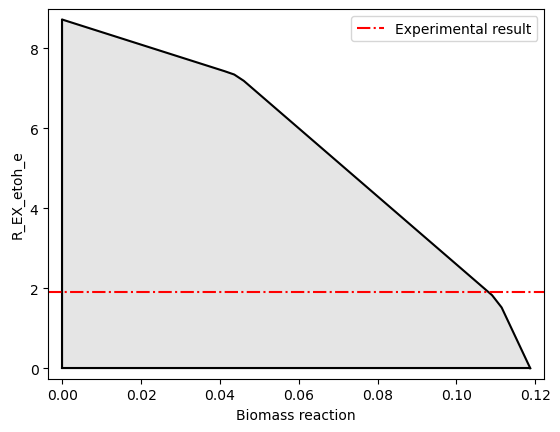

In [19]:
ax = reframed.cobra.plotting.plot_flux_envelope(model,'Growth','R_EX_etoh_e',constraints=constraints,steps=50)
ax.axhline(y = q_etoh, color = 'r', linestyle = '-.',label="Experimental result")
ax.legend()

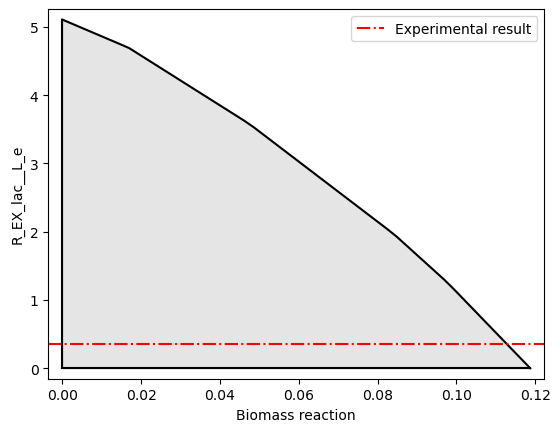

In [20]:
ax = reframed.cobra.plotting.plot_flux_envelope(model,'Growth','R_EX_lac__L_e',constraints=constraints,steps=50)
ax.axhline(y = q_lac, color = 'r', linestyle = '-.',label="Experimental result")
ax.legend()

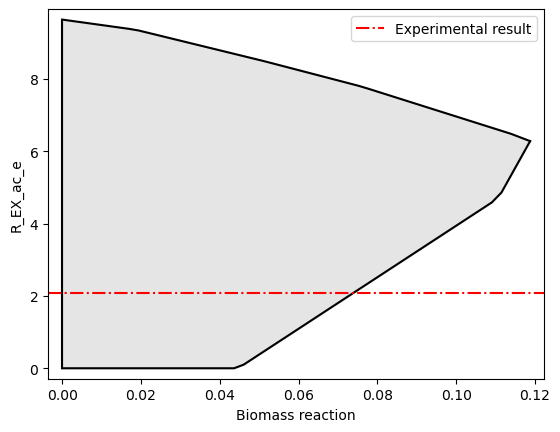

In [21]:
ax = reframed.cobra.plotting.plot_flux_envelope(model,'Growth','R_EX_ac_e',constraints=constraints,steps=50)
ax.axhline(y = q_ac, color = 'r', linestyle = '-.',label="Experimental result")
ax.legend()

## <span style="color: blue;">C: Testing the model on additional data from other sources.</span>

Daniel asked me to do additional testing of the model based on the data that I've found. Based on what he said I should limit it to testing of cases where I'm able to determine the exact yield/production rates. <span style="color: red;"> I looked through the list in the Update2 document and found the most relevant ones (Note that these are the ones that I used for CarveMe reconstruction, because they had a defined media). I should reevaluate the other studies as well.</span>

**Motivation**: Determine if GAM values are correct and find other targets for gap-filling/curation. 

**Overview**: 
- **B.1. Guedon et al. 1999. Testing growth at various dilution rates** 
    - *Article*: Carbon and electron flow in Clostridium cellulolyticumgrownin  chemostat  culture  on  synthetic  medium (Guedon et al., 1999)
    - They provide growth rate and production rates at different dilution rates. In the iFS431 model they  used this data to determine GAM values, and I want to replicate that experiment as well.  
- **B.2. Kampik et al. 2021: Testing growth of KO mutants.** 



### <span style="color: blue;">C.1.1 Guedon et al. 1999. Testing growth at various dilution rates.</span>

<span style="color: blue;">**Importing and reparing the model with media used in the study (same procedure as before)**</span>

In [22]:
with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    env_cellb=Environment.from_compounds(list(media[media.medium=='H10_defined_medium_cellobiose']['compound']))
    env_cellb.apply(model,exclusive=True,inplace=True)

<span style="color: blue;">**Importing additional data about uptake rates**</span>

In [23]:
chemostat= pd.read_excel('/Users/idunmariaburgos/Documents/Work/Project/Ruminiclostridium cellulolyticum part 2/Guedon1999_chemostat_data.xlsx', 
              sheet_name='Sheet1', 
              header=None, 
              index_col=0,
              usecols="A:H")
chemostat

,1,2,3,4,5,6,7
0,,,,,,,
mu (growth rate),0.016,0.033,0.053,0.062,0.085,0.12,0.138
qcellobiose (mmol [g of cells]−1h−1),0.630,0.890,1.340,1.410,1.550,1.86,1.980
qpyruvate (mmol [g of cells]−1h−1),1.630,2.730,2.980,3.210,3.790,4.27,4.350
Acetate,74.800,68.500,62.700,65.300,55.400,51.10,47.800
Lactate,2.800,2.000,2.500,4.500,6.600,11.50,8.300
Ethanol,22.500,29.500,34.900,30.600,38.000,37.50,43.900


<span style="color: blue;">**Using the data to test model**</span>

- For each case, report growth rate and production rates. Make several line-plots. (one for experimental and one for predicted, while varying max biomass production.


**For information**: 

Fermentation product production is given as percentage of pyruvate production rate. 
q(pyruvate) = q(ethanol) + q(acetate) + q(lactate)


<span style="color: blue;">**Extracting and processing experimental  data**</span>

In [24]:
#Data given in Guedon et al. (1999)
mu = np.array(chemostat.iloc[0,:].tolist())
q_cellb = np.array(chemostat.iloc[1,:].tolist())

q_pyr =  np.array(chemostat.iloc[2,:].tolist())
percent_ac = np.array(chemostat.iloc[3,:].tolist())
percent_lac = np.array(chemostat.iloc[4,:].tolist())
percent_etoh = np.array(chemostat.iloc[5,:].tolist())

# Calculating specific production rates.
q_ac = q_pyr * percent_ac /100 # Specific production
q_lac = q_pyr * percent_lac /100 # Specific production
q_etoh = q_pyr * percent_etoh /100 # Specific production



<span style="color: blue;">**Preparing constraints for analysis**</span>

In [25]:
# Constraints used in Salimi et al. (2010) for growth on cellobiose

constraints = {}
constraints = {'R_EX_so4_e':(-2.45,1000),
               'R_EX_pi_e':(-7.46,1000),
               'R_EX_nh4_e':(-4.9,1000)}




<span style="color: blue;">**Determining pFBA growth rate and fermentation product production rates**</span>

In [26]:
## pFBA prediction of growth rate and product production
mu_predict = []
q_pfba_predict_ac =[]
q_pfba_predict_lac=[]
q_pfba_predict_etoh=[]

for i,q_cellb_i in enumerate(q_cellb):
    constraints['R_EX_cellb_e']=(-q_cellb_i,0)
    sol = pFBA(model,constraints=constraints)
    
    mu_predict.append(sol.values['Growth']) 
    q_pfba_predict_ac.append(sol.values['R_EX_ac_e'])
    q_pfba_predict_lac.append(sol.values['R_EX_lac__L_e'])
    q_pfba_predict_etoh.append(sol.values['R_EX_etoh_e'])
    


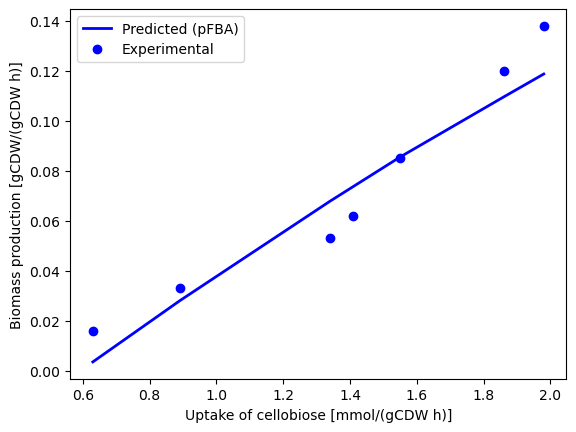

In [27]:
fig, ax = plt.subplots()
ax.plot(q_cellb,mu_predict, linewidth=2,label="Predicted (pFBA)",color='blue')
ax.plot(q_cellb,mu, 'bo',label="Experimental")
plt.ylabel(f'Biomass production [gCDW/(gCDW h)]')
plt.xlabel("Uptake of cellobiose [mmol/(gCDW h)]")

plt.legend(loc='upper left')
plt.show()



### <span style="color: blue;">C.1.2 Guedon et al. 1999. Testing fermentation product production at various dilution rates.</span>

<span style="color: blue;">**Determining fermentation product production rates while relaxing the biomass production**</span>

In [28]:
#  Used chatgpt to shorten code. Still doesn't look very nice. 
fermentation_products = ['R_EX_lac__L_e','R_EX_etoh_e','R_EX_ac_e']
q_predict = {'ac': OrderedDict(), 'lac': OrderedDict(), 'etoh': OrderedDict()}

## Prediction of fermentation product production with FVA while varying obj_frac and uptake rate

for x in range(5,11,1): # Specifying the objective fraction for FVA
    q_predict[x] = {'ac': [], 'lac': [], 'etoh': []} # Create new key-value pairs in q_predict that keep track of production based on x.
    
    for i,q_cellb_i in enumerate(q_cellb):    # Specifying uptake of cellobiose
        # Finding optimal solution for growth
        constraints['R_EX_cellb_e']=(-q_cellb_i,0)
        
        # Here I find the max and min production at the current objective fraction and uptake rate
        sol_FVA = FVA(model,obj_frac=x/10,reactions=fermentation_products,constraints=constraints) 
        
        # cellb is on top, and compound is lower level.
        q_predict[x]['ac'].append([sol_FVA['R_EX_ac_e'][1], sol_FVA['R_EX_ac_e'][0]]) 
        q_predict[x]['lac'].append([sol_FVA['R_EX_lac__L_e'][1], sol_FVA['R_EX_lac__L_e'][0]])
        q_predict[x]['etoh'].append([sol_FVA['R_EX_etoh_e'][1], sol_FVA['R_EX_etoh_e'][0]])
    
    # Changes the order of the dictionary to make input for ac, etoh and lac: compound is on top and cellb is lover level
    for product in fermentation_products:
        q_predict[product.split('_')[2]][f'max{x}0%'] = [y[0] for y in q_predict[x][product.split('_')[2]]] 
        q_predict[product.split('_')[2]][f'min{x}0%'] = [y[1] for y in q_predict[x][product.split('_')[2]]]
        


In [29]:
def plot_fermentation_product(pfba_predict, predict,experimental_prod,q_cellb,name):
    

    fig, ax = plt.subplots()
    
    # Fill in between pFBA and max 100
    
    filled_100_max = ax.fill_between(q_cellb, pfba_predict, predict['max100%'], alpha=.5, color='navy',linewidth=0)
    filled_100_min = ax.fill_between(q_cellb,  predict['min100%'], pfba_predict, alpha=.5, color='navy',linewidth=0)
    
    # Give percentage if there is more than 0 space for text
    if sum(np.array(pfba_predict)-np.array(predict['max100%']))!=0:
        (x0, y0), (x1, y1) = filled_100_max.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, (y0 + y1) / 2, "100%", ha='right', va='center', fontsize=10, color='black')
        
    # Give percentage if there is more than 0 space for text
    if sum(np.array(pfba_predict)-np.array(predict['min100%']))!=0:
        (x0, y0), (x1, y1) = filled_100_min.get_paths()[0].get_extents().get_points()
        ax.text((x0 + x1) / 2, (y0 + y1) / 2, "100%", ha='right', va='center', fontsize=10, color='black')
    
    
    # Fill in for all other areas
    colors = ['blue', 'dodgerblue', 'deepskyblue', 'darkturquoise', 'aquamarine']
    alphas = [.4, .3, .2, .1, .1]
    max_values = ['max100%', 'max90%', 'max80%', 'max70%', 'max60%', 'max50%']
    min_values = ['min100%', 'min90%', 'min80%', 'min70%', 'min60%', 'min50%']
    percentages = ['90%', '80%', '70%', '60%', '50%']

    for i, (color, alpha, max_value, min_value, percentage) in enumerate(zip(colors, alphas, max_values[:-1],min_values[:-1], percentages)):
        next_max_value = max_values[i+1]
        next_min_value = min_values[i+1]
        filled_max = ax.fill_between(q_cellb, predict[max_value], predict[next_max_value], alpha=alpha, color=color, linewidth=0)
        filled_min = ax.fill_between(q_cellb, predict[next_min_value],predict[min_value], alpha=alpha, color=color, linewidth=0)
        
        # Give percentage if there is more than 0 space for text
        if sum(np.array(predict[next_max_value])-np.array(predict[max_value]))!=0: 
            (x0, y0), (x1, y1) = filled_max.get_paths()[0].get_extents().get_points()
            ax.text((x0 + x1) / 2, (y0 + y1) / 2, percentage, ha='center', va='center', fontsize=10, color='black')
            
        # Give percentage if there is more than 0 space for text
        if sum(np.array(predict[next_min_value])-np.array(predict[min_value]))!=0: 
            (x0, y0), (x1, y1) = filled_min.get_paths()[0].get_extents().get_points()
            ax.text((x0 + x1) / 2, (y0 + y1) / 2, percentage, ha='center', va='center', fontsize=10, color='black')
        
    ax.plot(q_cellb,pfba_predict,'r',label="Predicted pFBA")
    ax.plot(q_cellb,experimental_prod,'go',label="Experimental")
    
    plt.ylabel(f'Production of {name} [mmol/(gCDW h)]')
    plt.xlabel("Uptake of cellobiose [mmol/(gCDW h)]")

    plt.legend(loc='upper left')
    plt.savefig(name+".png")
    plt.show()


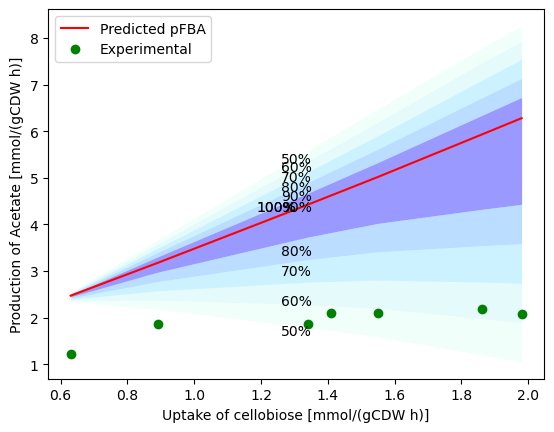

In [30]:
plot_fermentation_product(q_pfba_predict_ac,q_predict['ac'],q_ac,q_cellb,'Acetate')

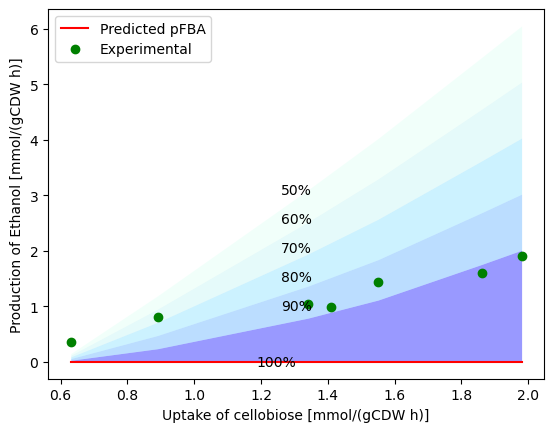

In [31]:
plot_fermentation_product(q_pfba_predict_etoh,q_predict['etoh'],q_etoh,q_cellb,'Ethanol')

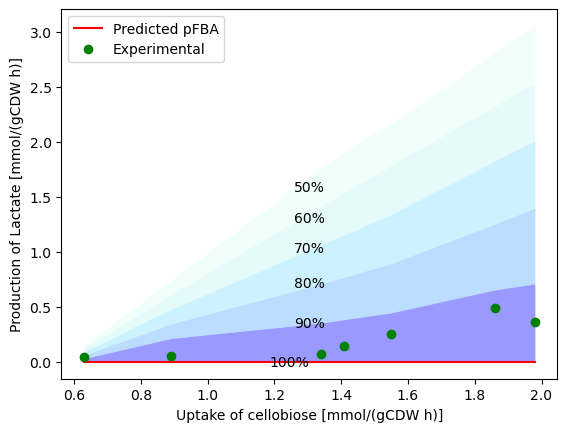

In [32]:
plot_fermentation_product(q_pfba_predict_lac,q_predict['lac'],q_lac,q_cellb,'Lactate')

### <span style="color: blue;">C.2: KO experiments with data from Kampik et al. (2021)</span>

They provided growth data for several mutants of R. cellulolyticum growing on various sugars. They specifically targeted genes that are believed to be important for the catabolism of one specific sugar, and studied the activity of these enzyme and their importance for the cells growth on that sugar and the other sugars.

Below you can see what the results where from their studied when a specific gene was inactivated. 

#### <span style="color: blue;">Gene KO experimental results</span>

In [33]:
mutant_growth = pd.read_excel('/Users/idunmariaburgos/Documents/Work/Project/Ruminiclostridium cellulolyticum part 2/gene_deletion.xlsx',
                              sheet_name="gene_deletion_boolean", 
                              usecols="A:H")


In [34]:
def conditions(v):
    if v == "Yes":
        return "Yes"
    elif v == "No":
        return "No"
    elif type(v)==float:
        return ""
    else:
        return v
    
def color_map(val):
    if val == 'Yes':
        color = 'background-color: springgreen'
    elif val == 'No':
        color = 'background-color: pink'
    else:
        color = 'background-color: white'
    return color

def make_pretty(styler):
    styler.format(conditions)
    styler.set_caption("Experimental results")
    styler.applymap(color_map)
    return styler


#### <span style="color: blue;"> Gene KO predicted results with pFBA </span>

In [35]:
with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    env_init=Environment.from_compounds(list(media[media.medium=='H10_minimal_glucose']['compound']))
    env_init.apply(model,exclusive=True,inplace=True)

In [36]:
# Growth of wild type 
wt_growth = []
sugars = ['R_EX_arab__L_e','R_EX_glc__D_e','R_EX_cellb_e','R_EX_gal_e','R_EX_xyl__D_e','R_EX_man_e']
for sugar in sugars:
    constraints = {'R_EX_glc__D_e':0}
    constraints[sugar] = (-10,0)
    wt_growth.append(reframed.pFBA(model,constraints=constraints).values['Growth'])
    
growth_wt = pd.DataFrame({'Sugars':sugars,'Growth WT':wt_growth})
growth_wt   

,Sugars,Growth WT
0,R_EX_arab__L_e,0.378511
1,R_EX_glc__D_e,0.554141
2,R_EX_cellb_e,1.001024
3,R_EX_gal_e,0.455428
4,R_EX_xyl__D_e,0.378511
5,R_EX_man_e,0.554141


In [37]:
%store -r gene_protein_map

In [38]:
from reframed.solvers.solution import Status
def test_mutant_growth_sugar(model,protein_id,sugar,growth_wt):
    sugar_to_id = {'Arabinose': 'R_EX_arab__L_e',
                   'Glucose': 'R_EX_glc__D_e',
                   'Cellobiose': 'R_EX_cellb_e',
                   'Galactose': 'R_EX_gal_e',
                   'Xylose': 'R_EX_xyl__D_e',
                   'Mannose': 'R_EX_man_e'}
    
    constraints = {'R_EX_glc__D_e':0}
    constraints[sugar_to_id[sugar]] = (-10,0)
    sol = reframed.cobra.knockout.gene_knockout(model, protein, method='pFBA', constraints=constraints)
    
    mu_wt = growth_wt.loc[growth_wt['Sugars'] ==sugar_to_id[sugar]]['Growth WT'].values[0]
    mu_ko = sol.values['Growth'] if sol.status==Status.OPTIMAL else 0.0
    return mu_ko/mu_wt, sol
    

In [39]:
solutions_arab = []
solutions_glc = []
solutions_cellb = []
solutions_gal = []
solutions_xyl = []
solutions_man = []
sol_FBA = {'Arabinose': [],
           'Glucose': [],
           'Cellobiose': [],
           'Galactose': [],
           'Xylose': [],
           'Mannose': []}

# For all genes in the list of mutants. For each iteration, a new mutant is tested
for gene in mutant_growth['Gene inactivation'].values:
    constraints = {'R_EX_glc__D_e':0}
    
    # Find protein id from gene id
    protein = list(gene_protein_map[gene_protein_map['Gene names'].str.contains(gene)]["Cross-reference (RefSeq)"])
    # Find the row of the gene in mutant gene
    growth_exp = mutant_growth.loc[mutant_growth['Gene inactivation'] == gene]
    
    # If growth was tested on Arabinose, test mutant growth
    if growth_exp['Arabinose'].values == 'No' or growth_exp['Arabinose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Arabinose',growth_wt)
        solutions_arab.append(rel_mu_mutant)
        sol_FBA['Arabinose'].append(sol)
    else:
        solutions_arab.append(' ')
    
    # If growth was tested on Glucose, test mutant growth 
    if growth_exp['Glucose'].values == 'No' or growth_exp['Glucose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Glucose',growth_wt)
        solutions_glc.append(rel_mu_mutant)
        sol_FBA['Glucose'].append(sol)
    else:
        solutions_glc.append(' ')
    
    # If growth was tested on Cellobiose, test mutant growth 
    if growth_exp['Cellobiose'].values == 'No' or growth_exp['Cellobiose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Cellobiose',growth_wt)
        solutions_cellb.append(rel_mu_mutant)
        sol_FBA['Cellobiose'].append(sol)
    else:
        solutions_cellb.append(' ')
        
    # If growth was tested on Galactose, test mutant growth   
    if growth_exp['Galactose'].values == 'No' or growth_exp['Galactose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Galactose',growth_wt)
        solutions_gal.append(rel_mu_mutant)
        sol_FBA['Galactose'].append(sol)
    else:
        solutions_gal.append(' ')
    
    # If growth was tested on Xylose, test mutant growth 
    if growth_exp['Xylose'].values == 'No' or growth_exp['Xylose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Xylose',growth_wt)
        solutions_xyl.append(rel_mu_mutant)
        sol_FBA['Xylose'].append(sol)
    else:
        solutions_xyl.append(' ')
    
    # If growth was tested on Mannose, test mutant growth 
    if growth_exp['Mannose'].values == 'No' or growth_exp['Mannose'].values == 'Yes':
        rel_mu_mutant, sol = test_mutant_growth_sugar(model,protein,'Mannose',growth_wt)
        solutions_man.append(rel_mu_mutant)
        sol_FBA['Mannose'].append(sol)
    else:
        solutions_man.append(' ')

In [40]:
mutant_growth_pred = pd.DataFrame({'Mutant':mutant_growth['Mutant'], 
                               'Gene inactivation': mutant_growth['Gene inactivation'],
                               'Arabinose':solutions_arab,
                               'Glucose':solutions_glc,
                               'Cellobiose':solutions_cellb,
                               'Galactose':solutions_gal,
                               'Xylose':solutions_xyl,
                               'Mannose':solutions_man})

In [41]:
def conditions2(v):
    if type(v)==str:
        return v
    elif v <0.1:
        return "No"
    elif v >=0.1:
        return "Yes"
    else:
        return v
    
def color_map2(val):
    if type(val)==str:
        color = 'background-color: white'
    elif val<0.1:
        color = 'background-color: pink'
    elif val >=0.1:
        color = 'background-color: springgreen'

    return color

def make_pretty2(styler,caption):
    styler.set_caption(caption)
    styler.format(conditions2)
    styler.applymap(color_map2)
    return styler

####  <span style="color: blue;"> Comparison </span>

In [42]:
mutant_growth_pred.style.pipe(make_pretty2,"Predictions with pFBA")

,Mutant,Gene inactivation,Arabinose,Glucose,Cellobiose,Galactose,Xylose,Mannose
0,MTL3221,Ccel_3221,Yes,No,No,,,No
1,MTL3238,Ccel_3238,Yes,,,No,,
2,MTL3429,Ccel_3429,Yes,,,,No,
3,MTL3431,Ccel_3431,Yes,,,,No,


In [43]:
mutant_growth.style.pipe(make_pretty)

,Mutant,Gene inactivation,Arabinose,Glucose,Cellobiose,Galactose,Xylose,Mannose
0,MTL3221,Ccel_3221,Yes,No,No,,,No
1,MTL3238,Ccel_3238,Yes,,,No,,
2,MTL3429,Ccel_3429,Yes,,,,Yes,
3,MTL3431,Ccel_3431,Yes,,,,No,


## <span style="color: blue;">D: ATP and biomass yield and growth rate on various sugars</span>

**Motivation**: Before adding pathways for oligosaccharide degradation we should have an idea of the predictions from growth and ATP production on simple sugars. 


- **D.1 ATP yield on various sugars**
    - **Cellobiose**: Study of ATP yield on cellulose and cellobiose - *Cellulose Catabolism by Clostridium cellulolyticum Growing in Batch Culture on Defined Medium (Desvaux, 2000)*.  
        - In this study they did an estimation of the energy gain, based on the known metabolic reactions involved in fermentation of cellodextrins. They therefore calculated ATP production from the fermentation products it produces (see table below). This is also just the maximum possible based on one fermentation product. Nevertheless, it can be used as a comparison with our data. <span style="color: red;"> NB: Note to self. There are also other articles that calculate the same thing, so make sure that you don't base everything on just one article. </span>

    - **Other sugars**: Don't have specific data from *R. cellulolyticum* for comparison. The aim is to verify that the model can use all of these sugars as an energy source. To check this, you should look at the shadow-prices and the reduced cost, not just the maximum ATP produced with the media. Or else, you won't know whether the energy comes from the compound you're testing or not. 

- **D.2 Growth rate**: We can also test the growth in comparison to the growth from the experiments in Kampik et al. (2021). We can ask them for the data from this experiment. 
    - This would be valuable when we are trying to model growth on more complex polysaccharides (We should put some limit on the uptake of these sugars We will probably not let the model grow on simple sugars, so it is maybe not necessary to do this. 



- **ATP production from various fermentation products** 

### <span style="color: blue;">D.1. Maximal ATP yield on various sugars</span>

As explained by Salimi et al (2010), the ATP yield from cellobiose is more than double the energy gain for glucose. This is because it saves some energy on transport (ABC-transporter requires 2 ATP per transport), and because of the extra energy in the catabolism of glucose-1-phosphate. 

In [44]:
with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    env_init=Environment.from_compounds(list(media[media.medium=='H10_minimal_glucose']['compound']))
    env_init.apply(model,exclusive=True,inplace=True)

<span style="color: red;">**In part 1.1.1. I also added constraints on cysteine and no3 uptake, but this is not included here.**</span>

In [45]:
sugars = ['R_EX_glc__D_e','R_EX_cellb_e','R_EX_xyl__D_e','R_EX_arab__D_e','R_EX_arab__L_e','R_EX_gal__L_e','R_EX_gal_e','R_EX_man_e']

objective = dict.fromkeys(model.reactions,0)
objective['R_ATPM'] = 1
atp_dict = {}

for sugar_id in sugars:
    with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
        warnings.simplefilter('ignore')
        constraints ={'R_EX_glc__D_e':0}
        constraints[sugar_id] = (-10,0)
        sol = FBA(model,objective=objective,constraints=constraints)
        atp_dict[sugar_id]=sol

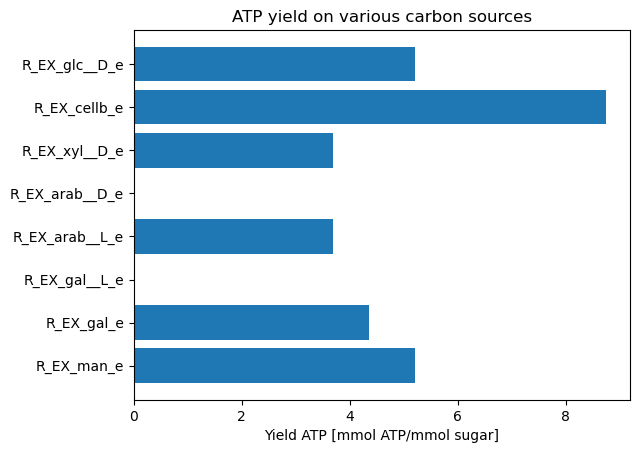

In [46]:
keys = [medium for medium in atp_dict.keys()]
values = [sol.fobj/10 if sol.status==Status.OPTIMAL else 0.0 for sol in atp_dict.values()]
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(keys))
atp_rate = values 


ax.barh(y_pos, atp_rate, align='center')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Yield ATP [mmol ATP/mmol sugar]')
ax.set_title('ATP yield on various carbon sources')
plt.show()



### <span style="color: blue;">D.2. Maximal growth rate on various sugars</span>

In [47]:
with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
    warnings.simplefilter('ignore')
    env_init=Environment.from_compounds(list(media[media.medium=='H10_minimal_glucose']['compound']))
    env_init.apply(model,exclusive=True,inplace=True)

In [48]:
sugars = ['R_EX_glc__D_e','R_EX_cellb_e','R_EX_xyl__D_e','R_EX_arab__D_e','R_EX_arab__L_e','R_EX_gal__L_e','R_EX_gal_e','R_EX_man_e']

objective = dict.fromkeys(model.reactions,0)
objective['Growth'] = 1
growth_dict = {}

for sugar_id in sugars:
    with warnings.catch_warnings(): # The code will create warnings because some of the compounds in the media are not in the model
        warnings.simplefilter('ignore')
        constraints ={'R_EX_glc__D_e':0}
        constraints[sugar_id] = (-10,0)
        sol = FBA(model,objective=objective,constraints=constraints)
        growth_dict[sugar_id]=sol

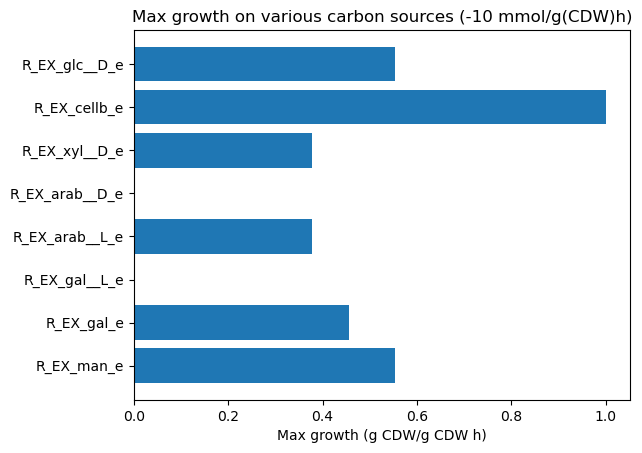

In [49]:
keys = [medium for medium in growth_dict.keys()]
values = [sol.fobj if sol.status==Status.OPTIMAL else 0.0 for sol in growth_dict.values()]
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(keys))
growth_yield = values 

ax.barh(y_pos, growth_yield, align='center')
ax.set_yticks(np.arange(len(keys)))
ax.set_yticklabels(keys)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Max growth (g CDW/g CDW h)')
ax.set_title('Max growth on various carbon sources (-10 mmol/g(CDW)h)')
plt.show()